In [1]:
### Ref: https://github.com/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb


# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# For basic Image IO
import IPython.display as display
from PIL import Image

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

#Add basic logging
import logging
logging.basicConfig(filename='cs230_keras_notebook.log',
                    level=logging.DEBUG,
                   format='%(asctime)s %(message)s', 
                    datefmt='%m/%d/%Y %I:%M:%S %p')

In [2]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
def show_batch(image_batch, label_batch, class_indices):
    print("image_batch_shape {}".format(image_batch.shape))
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        label_indices = np.argmax(label_batch[n])
        
        #Flip the dictionary from class_indices to indices_class
        indices_class = dict((v,k) for k, v in class_indices.items()) 
        plt.imshow(image_batch[n])
        plt.title(label_batch[n])
        plt.title(indices_class.get(label_indices))
        plt.axis('off')

In [6]:
def show_batch_grayscale(image_batch, label_batch):
    print("image_batch_shape {}".format(image_batch.shape))
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(np.squeeze(image_batch[n]), cmap='gray',interpolation='none')
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

In [7]:
#This assumed that you have checked out the data repo next to the object detection repo
# Data repo can be found over here: https://github.com/nandini-sundar/CS230-TrashNet-YOLO-Labeled
import pathlib
data_dir = pathlib.Path("../CS230-TrashNet-YOLO-Labeled")

In [8]:
class_names_file = data_dir.joinpath("classes.txt")
class_names = pd.read_csv(class_names_file, header = None, sep='\n', names=['classes'])
print(class_names.values)

[['glass']
 ['metal']
 ['plastic']
 ['cardboard']
 ['trash']
 ['paper']]


In [9]:
np.array(class_names)

array([['glass'],
       ['metal'],
       ['plastic'],
       ['cardboard'],
       ['trash'],
       ['paper']], dtype=object)

In [10]:
import shutil

data_images_dir = data_dir.joinpath("Images")
CLASS_NAMES = np.array([item.name for item in data_images_dir.glob('*') if item.name != "LICENSE.txt"])

CLASS_NAMES

#Make directory to save generated images
generated_train_images_dir = data_dir.joinpath("generated/train")
generated_validation_images_dir = data_dir.joinpath("generated/validation")
generated_test_images_dir = data_dir.joinpath("generated/test")
if not os.path.exists(generated_train_images_dir):
    os.makedirs(generated_train_images_dir)
    os.makedirs(generated_validation_images_dir)
    os.makedirs(generated_test_images_dir)
else: #Empty the directory
    shutil.rmtree(generated_train_images_dir)
    shutil.rmtree(generated_validation_images_dir)
    shutil.rmtree(generated_test_images_dir)
    
    os.makedirs(generated_train_images_dir)
    os.makedirs(generated_validation_images_dir)
    os.makedirs(generated_test_images_dir)
    
logging.info("Generated train images stored at {}".format(generated_train_images_dir))
logging.info("Generated validation images stored at {}".format(generated_validation_images_dir))
logging.info("Generated test images stored at {}".format(generated_test_images_dir))

In [11]:
image_count = len(list(data_images_dir.glob('*/*.jpg')))
print("Total number of input images {}".format(image_count))

Total number of input images 2527


In [13]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [14]:
def get_dataframe_for_generator(filename, x_col, y_col):
    df = pd.read_csv(data_dir.joinpath(filename), names=[x_col])
    
    #Convert foldernames in filepaths to class names.
    #Expects filepath in format : ./Images/paper/paper283.jpg
    df[y_col] = df[x_col].apply(lambda x: os.path.basename(os.path.dirname(x)))
    
    return df
    
x_col = "filename"
y_col = 'class_list'

train_df = get_dataframe_for_generator(filename='train.txt', x_col=x_col, y_col=y_col)
logging.debug("Here are some train images ")
logging.debug(train_df)

test_df = get_dataframe_for_generator(filename='test.txt', x_col=x_col, y_col=y_col)
logging.debug("Here are some test images ")
logging.debug(test_df)

In [15]:
train_df

,filename,class_list
0,./Images/paper/paper283.jpg,paper
1,./Images/paper/paper297.jpg,paper
2,./Images/paper/paper526.jpg,paper
3,./Images/paper/paper240.jpg,paper
4,./Images/paper/paper254.jpg,paper
...,...,...
2270,./Images/plastic/plastic405.jpg,plastic
2271,./Images/plastic/plastic411.jpg,plastic
2272,./Images/plastic/plastic377.jpg,plastic
2273,./Images/plastic/plastic439.jpg,plastic


In [33]:
train_df[x_col].str.split(pat='/')

0           [., Images, paper, paper283.jpg]
1           [., Images, paper, paper297.jpg]
2           [., Images, paper, paper526.jpg]
3           [., Images, paper, paper240.jpg]
4           [., Images, paper, paper254.jpg]
                        ...                 
2270    [., Images, plastic, plastic405.jpg]
2271    [., Images, plastic, plastic411.jpg]
2272    [., Images, plastic, plastic377.jpg]
2273    [., Images, plastic, plastic439.jpg]
2274    [., Images, plastic, plastic388.jpg]
Name: filename, Length: 2275, dtype: object

In [38]:
def split_and_join(s, repl):
    splits = str.split(s, '/')
    splits[1] = repl
    return "/".join(splits)

In [41]:
train_df['label_path']  = train_df[x_col].str.replace(pat='.jpg', repl='.txt')
train_df['label_path'] = train_df['label_path'].apply(lambda x: split_and_join(x, 'Labels'))

In [42]:
train_df

,filename,class_list,label_path
0,./Images/paper/paper283.jpg,paper,./Labels/paper/paper283.txt
1,./Images/paper/paper297.jpg,paper,./Labels/paper/paper297.txt
2,./Images/paper/paper526.jpg,paper,./Labels/paper/paper526.txt
3,./Images/paper/paper240.jpg,paper,./Labels/paper/paper240.txt
4,./Images/paper/paper254.jpg,paper,./Labels/paper/paper254.txt
...,...,...,...
2270,./Images/plastic/plastic405.jpg,plastic,./Labels/plastic/plastic405.txt
2271,./Images/plastic/plastic411.jpg,plastic,./Labels/plastic/plastic411.txt
2272,./Images/plastic/plastic377.jpg,plastic,./Labels/plastic/plastic377.txt
2273,./Images/plastic/plastic439.jpg,plastic,./Labels/plastic/plastic439.txt


In [14]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  horizontal_flip = True, 
                                                                  vertical_flip = True, 
                                                                  zoom_range = 0.5, 
                                                                  shear_range = 0.5,
                                                                 validation_split=0.25)

train_generator = image_generator.flow_from_dataframe(dataframe=train_df,
                                                     directory=data_dir,
                                                     x_col=x_col,
                                                     y_col=y_col,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical',
                                                    save_to_dir=generated_train_images_dir,
                                                     subset="training",
                                                      subdirectories=True,
                                                    save_prefix="gen-")

Found 1707 validated image filenames belonging to 6 classes.


In [15]:
train_generator.batch_size


32

In [16]:
validation_data_gen = image_generator.flow_from_dataframe(dataframe=train_df,
                                                     directory=data_dir,
                                                     x_col=x_col,
                                                     y_col=y_col,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                    seed=SEED,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical',
                                                    save_to_dir=generated_validation_images_dir,
                                                     subset="validation",
                                                    save_prefix="gen-")

Found 568 validated image filenames belonging to 6 classes.


In [17]:
#Notice that y_col = None
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen = test_generator.flow_from_dataframe(dataframe=test_df,
                                                     directory=data_dir,
                                                     x_col=x_col,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                    seed=SEED,
                                                   class_mode=None, 
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    save_to_dir=generated_test_images_dir,
                                                    save_prefix="gen-")

Found 252 validated image filenames.


In [18]:
image_batch, label_batch = next(train_generator)
image_batch.shape

(32, 224, 224, 3)

In [19]:
# train_data_gen.classes

image_batch_shape (32, 224, 224, 3)


/home/hnkulkarni/envs/cs230/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


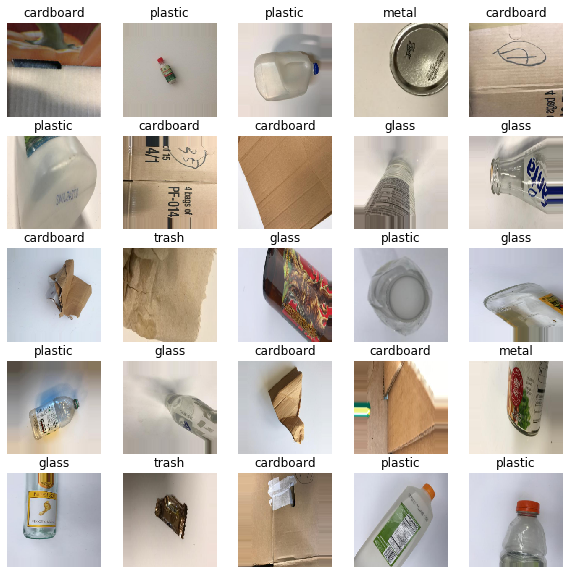

In [20]:
show_batch(image_batch, label_batch, train_generator.class_indices)
#TODO: Convert ONE-HOT Labels back to category labels

In [21]:
base_model = keras.applications.xception.Xception(weights='imagenet',
                                                 include_top = False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(len(train_generator.class_indices), activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [22]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [23]:
validation_data_gen.samples/validation_data_gen.batch_size

17.75

In [24]:
for layer in base_model.layers:
    layer.trainable = False
    
adam = tf.keras.optimizers.Adam(lr=0.01) #Higher lerarning rate
model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_generator, epochs=2, workers=8, 
                                       steps_per_epoch=train_generator.samples // BATCH_SIZE, 
                                       shuffle=True,
                            validation_data=validation_data_gen)

Epoch 1/2
53/53 [==============================] - 24s 455ms/step - loss: 0.8959 - accuracy: 0.6693 - val_loss: 15.2889 - val_accuracy: 0.0158
Epoch 2/2
53/53 [==============================] - 24s 453ms/step - loss: 0.6840 - accuracy: 0.7577 - val_loss: 15.2299 - val_accuracy: 0.0282


In [25]:
#Unfreeze the layers from the base model
for layer in base_model.layers:
    layer.trainable = True
    
adam = tf.keras.optimizers.Adam(lr=0.000001) #Lower the lerarning rate lerarning rate
model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_generator, epochs=20, workers=8, 
                                       steps_per_epoch=train_generator.samples // BATCH_SIZE, 
                                       shuffle=True,
                              validation_data=validation_data_gen)

Epoch 1/20
53/53 [==============================] - 28s 534ms/step - loss: 0.5289 - accuracy: 0.7887 - val_loss: 15.1738 - val_accuracy: 0.0335
Epoch 2/20
53/53 [==============================] - 28s 526ms/step - loss: 0.4997 - accuracy: 0.8137 - val_loss: 15.1635 - val_accuracy: 0.0440
Epoch 3/20
53/53 [==============================] - 28s 528ms/step - loss: 0.4960 - accuracy: 0.8209 - val_loss: 15.2325 - val_accuracy: 0.0423
Epoch 4/20
53/53 [==============================] - 28s 526ms/step - loss: 0.5073 - accuracy: 0.8078 - val_loss: 15.2097 - val_accuracy: 0.0440
Epoch 5/20
53/53 [==============================] - 28s 531ms/step - loss: 0.5058 - accuracy: 0.8101 - val_loss: 15.1324 - val_accuracy: 0.0387
Epoch 6/20
53/53 [==============================] - 28s 522ms/step - loss: 0.4604 - accuracy: 0.8271 - val_loss: 14.9905 - val_accuracy: 0.0493
Epoch 7/20
53/53 [==============================] - 28s 530ms/step - loss: 0.4859 - accuracy: 0.8239 - val_loss: 14.8852 - val_accuracy:

In [26]:
train_generator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [27]:
indices_class = dict((v,k) for k, v in train_generator.class_indices.items())

In [28]:
print(indices_class)

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


image_batch_shape (32, 224, 224, 3)


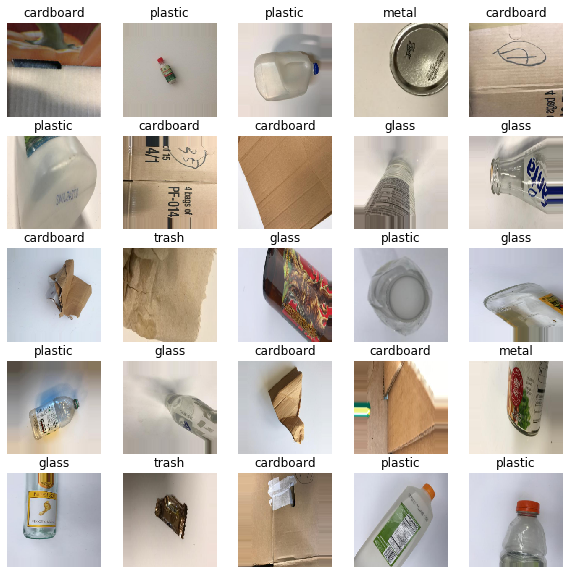

In [29]:
show_batch(image_batch, label_batch, train_generator.class_indices)